In [1]:
%matplotlib inline
import pymc as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
import seaborn as sns
np.random.seed(44)


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [7,3],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})
sns.set(rc={'figure.figsize':(7,3)})

# Normal-normal models  in probabilistic programming


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on.. 


*   Chapter 2 of O. Martin, *Bayesian Analysis with Python, Second Edition*.

*  Notebook by G. Corani

#  Inference about the speed of light

* At the end of the 19th century  Newcomb carried out several experiments to determine the speed of light.

* He measured how much  time it took for the light to travel a certain distance.

In [3]:
#Below  the  66 measurements.

data = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])


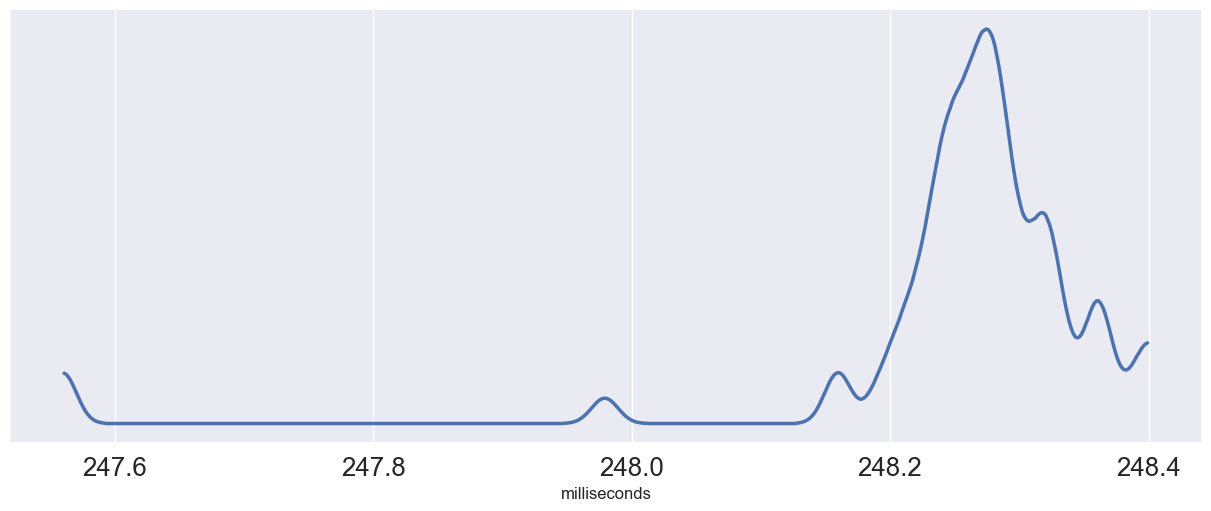

In [4]:
# The data are almost  normally distributed, apart from some  low-values outliers  which are far from the mean.
#the density plot is called kde (kernel density estimation)
az.plot_kde(data, figsize=[12,5])
plt.yticks([])
plt.xlabel('milliseconds');

# Normal - normal model


\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu})  && \text{prior uncertainty on } \mu\\
\sigma & \sim \text{HalfNormal} (\xi) &&  \text{prior uncertainty on } \sigma\\
\vec{y} & \sim N(\mu, \sigma) && \text{distribution of the data given } \mu \text{ and } \sigma \\
\end{align*}

* The observations $\vec{y}=\{y_1,y_2,y_n\}$ are assumed to be independent.


In [5]:
# Implementation with  informative priors 

with pm.Model() as model_newcomb:
    #prior for the location of mu
    # Based on prior information,  mu should lie within the interval (120,  360).
    # This corresponds to a normal distribution with mu = 240, sigma = 60
    mu = pm.Normal('mu', 240, 60)
    
    #Based on prior information, a plausible value for the standard deviation of the noise is 2.
    # This is roughly the median value of the halfnormal distribution with scale set to 3.
    sigma = pm.HalfNormal('sigma', 3)

    
    #likelihood. Each observation is a sample from N(mu, sigma).
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)
    
    trace_newcomb = pm.sample( return_inferencedata= True )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


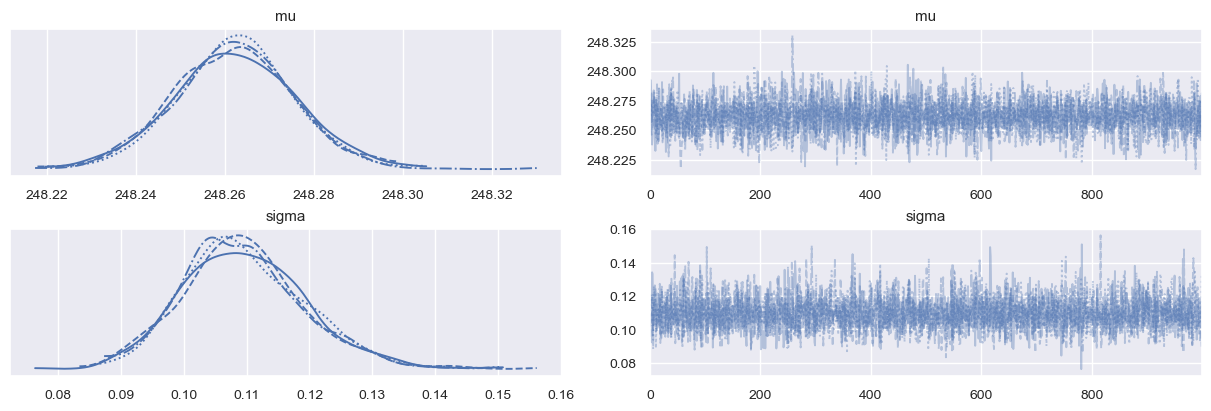

In [6]:
# The  density plots of  both parameters are smooth and the chains are well-mixing.

with  model_newcomb:
    az.plot_trace(trace_newcomb);

# What if we change the prior?

In [7]:
with pm.Model() as model_newcomb_2:

    #mu = pm.Normal('mu', 240, 60)
    #we assume to have  different prior information  about mu; larger mean and larger uncertainty.
    mu = pm.Normal('mu', 300, 100)
    
    #identical to the previous model
    sigma = pm.HalfNormal('sigma', 3)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)
    
    trace_newcomb_2 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [8]:
# The posterior is practically identical under the two different priors.
# This is  good: the data are strong enough to converge to the same posterior.
# The likelihood overwhelms the prior; the results are thus robust to the specification of the prior.


a = az.summary(trace_newcomb) 
b = az.summary(trace_newcomb_2) 
pd.concat([a,b])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.262,0.013,248.235,248.286,0.0,0.0,3788.0,2537.0,1.0
sigma,0.110,0.010,0.091,0.127,0.0,0.0,3698.0,2742.0,1.0
mu,248.262,0.014,248.234,248.286,0.0,0.0,3991.0,2862.0,1.0
sigma,0.109,0.010,0.092,0.128,0.0,0.0,4321.0,3167.0,1.0


# Posterior *point* prediction 

* Make a prediction about the next measurement $y^{\text{new}}$.  


* The simplest answer is to use the posterior mean (248.262, see previous slide). This is referred to as a point prediction. There is no quantification of the uncertainty.


#  Predictive distribution

* Provides the probability distribution for the next measurement $y^{\text{new}}$., whose mean is the point prediction.


*  The outcome $y^{\text{new}}$  is uncertain because it is  sampled from a distribution (thus it is stochastic, not deterministic)


*  There is uncertainty about  the value of  parameters of $\mu$ and  $\sigma$


# Computing the predictive distribution

* The trace contains e.g. 4000 parameter samples. Each sample contains both a value of $\mu$ and $\sigma$; this is a numerical approximation of their posterior joint density.

* We denote a generic posterior sample as  $<\mu_s, \sigma_s >$.  

* When sampling with posterior samples,  always use   $\mu_s$ together with its mate  $\sigma_s$ (do not use $\mu_s$  with $\sigma_{s+1}$, for instance). That is because $\mu$ and $\sigma$ are correlated in the posterior.
 



# Computing the predictive distribution

* We compute a different prediction from  each parameter sample  $<\mu_s, \sigma_s >$ :

$$
\left[
\begin{array}{ll} 
\mu_1 &   \sigma_1 \\
\mu_2 & \sigma_2 \\
\vdots & \vdots  \\
\mu_{4000}  & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l} 
y^{\text{new}}_{1} \\
y^{\text{new}}_{2} \\
\vdots \\
y^{\text{new}}_{4000} \\
\end{array}
\right]
$$

where  prediction referring to sample $s$ is computed as:

$$y^{\text{new}}_{s} \; \sim \; N\left(\mu_s, \sigma_s\right)\;\; $$


The  set of 4,000 values of $y_{\text{new}}$ approximates the  prediction distribution of a new measurement.

In [9]:
#Your turn: implement probabilistic prediction for the model

#extract samples from the trace, merging samples from the different chains
post_samples = az.extract(trace_newcomb.posterior)

#vector of samples of each parameter
mu_post = post_samples.mu.values
sigma_post = post_samples.sigma.values

#vector containing the predictions.
y_new = np.zeros(len(mu_post))

#your code: compute a probabilistic prediction from each pair of  value <mu_s sigma_s>
#compute the 95% HDI of your prediction
#plot the kde of the sample values of y_new using az.plot_kde(y_new)

In [10]:
# The posterior prediction can be computed convienently by adding a line to our pymc3 code.


with pm.Model() as model_newcomb_with_pred:
    #model as before (first variant)
    mu = pm.Normal('mu', 240, 80)
    sigma = pm.HalfNormal('sigma', 3)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)
    
    #prediction
    #for each sample value mu_s and sigma_s, a prediction is generated as N(mu_s, sigma_s).
    prediction = pm.Normal('prediction', mu=mu, sigma=sigma)
        
    trace_newcomb_with_pred = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, prediction]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [11]:
#the percentiles are equivalent to those previously computed in the exercise
az.summary(trace_newcomb_with_pred, var_names='prediction', hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prediction,248.263,0.109,248.052,248.469,0.001,0.001,5770.0,3160.0,1.0


# Posterior predictive checks


*  Even if the sampling has converged correctly, the model might be inadequate.


 * Idea:
 
 
       *  compute the predictive distribution;
       
       
       * verify that the predictive distribution o resembles the distribution of the actual data.



* This is called posterior predictive checks.



# Posterior predictive checks

* We  need  less samples for computing PPC relative to the MCMC sample.
 
The  `sample_posterior_predictive` function receives as parameter the number $n$ of desired samples and then: 

1. it randomly choose $n$ samples of type $< \mu_s, \sigma_s>$ from the trace;
2. it generates synthetic observations as discussed.

* Eventually we need to check that the sampled observations follow a distribution similar to the observed data.




In [12]:
with model_newcomb:
    # select 500 samples <mu_s ,sigma_s> from the trace
    # for each samples, compute a draw N(mu_s ,sigma_s) 
    # The ppc variable is a dictionary, with the keys being the name of the observed variable in our model and the values an array of shape (samples, size). 
    # The dictionary allows dealing with models with more than one observed variable. 
    ppc = pm.sample_posterior_predictive(trace_newcomb)

Sampling: [y]


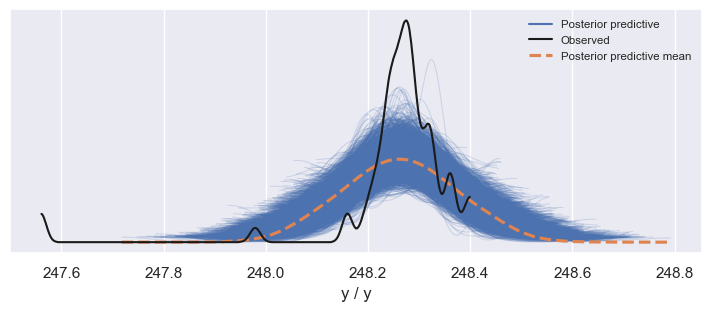

In [13]:
# The density related to each mu_s and sigma_s is shown. The average density is also shown.
# The density reproduced by the model is too low around the center.
# That is becaude the  variance is thus too large, in order to assign some probability also to the outliers. 
az.plot_ppc(ppc);

#  Robust models

* Outliers are too far from the mean  for the normal model. 

* These points could be due to experimental errors. If we are sure that this is the case,  we could remove them from our dataset (leaving a record of the removal and the reasons why we did it). 

* A more principled approach option is to adopt a likelihood which is *robust* to outliers.

#  The normal distribution has light tails

* The normal distribution is  sensitive to outliers. 


* The probability of finding a value falls rapidly as we move away from the mean; it is practically 0 when we are more than 3 standard deviation from the mean.


* If the data contains observations which are even further from the mean, the normal distribution is not a good model. 


* Probability of lying *outside* the interval $[ \mu - k \sigma, \mu + k \sigma]$:

| k |   \begin{equation} P \end{equation}|
|:-:|-:-|
| 3 | 0.0026 |
| 4 | 0.00006 |

# Student's t distribution


<img src='img/Student_t.png' width=400 align="center" > 

* It is defined by a mean, a scale $\sigma$ (related to the spread of the distribution) and by $\nu$ ( *degrees of freedom*  or as *normality* coefficient).

*  $\nu$ controls how _heavy_ the tails of the distribution are. 

    *  $\nu > 30$: the Student is practically equivalent to a Gaussian. 

    * $\nu = 4$ is a common choice to have a robust model with heavy tails, which can model observations that are far away from the mean.

# Discussion

* The Student probability density decays as a polynomial function of the squared distance from the center, as opposed to an exponential function of the Gaussian.


* So there is more probability mass in the tail compared  with a Gaussian distribution: it has *heavy* tails, which allows modelling  outliers.


* For $\nu$  ≫ 5, the Student distribution rapidly approaches a Gaussian distribution and loses its robustness properties.

# Comparing the normal and the Student-t distribution


* Probability of lying *outside* the interval $(\mu - k \sigma, \mu + k \sigma)$:


| k |   Normal | Student ($\nu$=4)
|:-:|-:-|-:-|    
    | 3 | 0.002 | 0.04 |
    | 4 | 0.00006 | 0.02 |
    
* The 99% interval is:

    * $\mu \pm 2.58 \sigma$ for the normal distribution;
   
    * $\mu \pm 4.61 \sigma$ for the Student-t distribution ($\nu$=4)

# Robust probabilistic model

\begin{align*}
\mu &\sim N(\mu', \sigma_{\mu}) && \text{prior beliefs about } \mu\\ 
\sigma &\sim \text{Half-Normal}(\xi) && \text{prior beliefs about } \sigma \\
y & \sim StudentT (\mu, \sigma, \nu=4) && \text{robust model of the observations} 
\end{align*}

In [14]:
with pm.Model() as model_t:
    #the priors are the same as those of  the first variant
    mu_t    = pm.Normal('mu_t', 240, 80)
    sigma_t = pm.HalfNormal('sigma_t', sigma=3)

    #robust likelihood
    y       = pm.StudentT('y', mu=mu_t, sigma=sigma_t, nu=4, observed=data)

    #prediction for a new measurement
    #prediction = pm.StudentT('prediction', mu=mu_t, sd=sigma_t, nu=4)
        
    trace_t = pm.sample(return_inferencedata=True) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_t, sigma_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [15]:
# The estimate of mu is  identical in the two cases.
# But the Student model  estimates a much lower  sigma than the normal model. 
# The t- distribution gives less weight (being less surprised) to values away from the mean; it does not need inflating  the  variance.
#  This allows keeping higher the density around the bulk of the data, as it will be shown by the posterior predictive check.


with model_t:
    summary_t = az.summary(trace_t)
with model_newcomb:
    summary= az.summary(trace_newcomb)
pd.concat([summary, summary_t])[ ["mean","sd" ]]

,mean,sd
mu,248.262,0.013
sigma,0.110,0.010
mu_t,248.275,0.007
sigma_t,0.047,0.006


Sampling: [y]


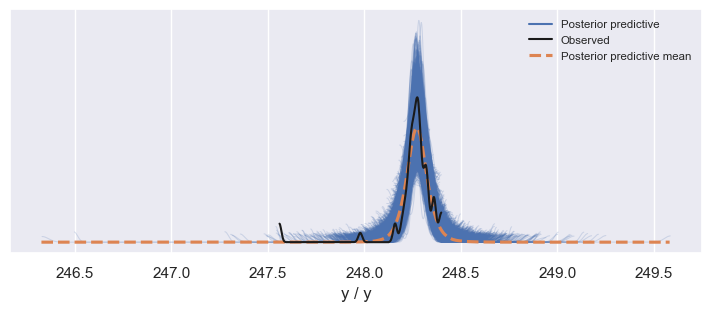

In [16]:
with model_t:
    ppc_t = pm.sample_posterior_predictive(trace_t)
    
az.plot_ppc(ppc_t);

# Your turn - 1

* compute and compare  the predictive distribution for the next value $y^{new}$,  using the Gaussian and  the Student likelihood


* hint: use the function `t.rvs` to sample from a Student-t distribution, and remember to specify the same degrees of freedom of the likelihood function ($\nu$=4 in our case). 

# Your turn - 2


* Using the speed of light data, calculate the mean and standard deviation with and without the _outliers_, compare those values ​​with those obtained with the gaussian and the robust model.


* Hint: consider outliers the observations which are more distant than 3.5 standard deviations from the mean.


* Is it beneficial to adopt a robust likelihood to analyze the data?

# Solutions

In [17]:
# probabilistic prediction: normal case

#extract samples from different chains
post_samples = az.extract(trace_newcomb.posterior)
mu_post = post_samples.mu.values
sigma_post = post_samples.sigma.values

#your code: compute a probabilistic prediction for the next observation
y_new = np.zeros(len(mu_post))

#we should use together  the values of sigma e mu referrring to the same sample 
for i, current_mu in enumerate(mu_post):
        y_new[i] = np.random.normal (loc = mu_post[i], scale = sigma_post[i])

pd.DataFrame(y_new).describe(percentiles=[0.025, 0.975])        

,0
count,4000.000000
mean,248.259883
std,0.111867
min,247.852397
2.5%,248.042628
50%,248.259799
97.5%,248.480555
max,248.678438


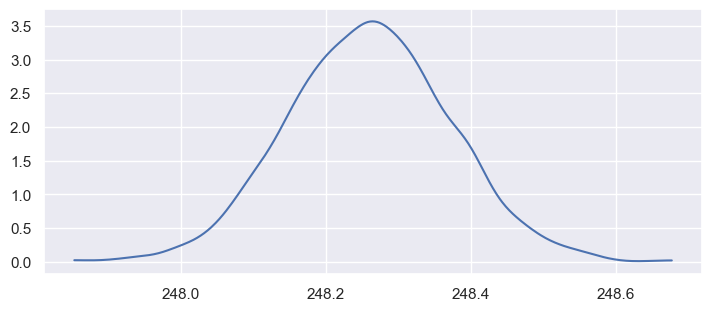

In [18]:
az.plot_kde(y_new);

In [19]:
# predictive distribution with the Student likelihood
from scipy.stats import t

#the  samples have been already extracted  in the previous cell
post_samples_t = az.extract(trace_t.posterior)
mu_post_t = post_samples_t.mu_t.values
sigma_post_t = post_samples_t.sigma_t.values

#your code: compute a probabilistic prediction for the next observation
y_new_t = np.zeros(len(mu_post_t))

#we should use together  the values of sigma e mu referrring to the same sample 
for i, current_mu in enumerate(mu_post):
        y_new_t[i] = t.rvs (loc = mu_post_t[i], scale = sigma_post_t[i], df=4)

pd.DataFrame(y_new_t).describe(percentiles=[0.025, 0.975])        

,0
count,4000.000000
mean,248.273383
std,0.065957
min,247.695319
2.5%,248.138330
50%,248.274947
97.5%,248.402158
max,248.790965


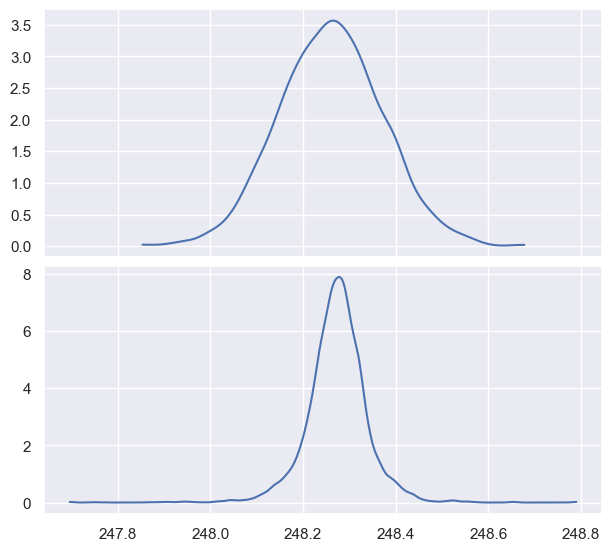

In [20]:
#here we visually compare the predictive distribution of the model with Gaussian and  Studend likelihood.
#the t distribution has higher density around the mean; at the same time it has  longer tails.

#to make the visual comparison,  we set up two plots with a shared x-axis
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 5.4), sharex=True)
plt.subplot(2,1,1)
az.plot_kde(y_new);
plt.subplot(2,1,2)
az.plot_kde(y_new_t);

# Fitting the model with Gaussian likelihood after removing outliers


In [21]:
#Below  the  66 measurements.

data = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])

xbar= np.mean(data)
s = np.std(data)

#the criterion for detecting outliers is a heuristic one.
#here we consider as outliers observations which are more than 3.5 std far from the mean.

# we remove observations lower than xbar - 3.5 sigma
data2 = data [data > xbar - 3.5 * s]  

# we remove observations larger than xbar +3.5 sigma
data2 = data2 [data2 < xbar + 3.5 * s]  

#one observation has been removed
print(len(data))
print(len(data2))

66
65


In [22]:
with pm.Model() as model_newcomb_no_outliers:
    #prior for the location of mu
    # Based on prior information,  mu should lie within the interval (120,  360).
    # This corresponds to a normal distribution with mu = 240, sigma = 60
    mu = pm.Normal('mu', 240, 60)
    
    #Based on prior information, a plausible value for the standard deviation of the noise is 2.
    # This is roughly the median value of the halfnormal distribution with scale set to 3.
    sigma = pm.HalfNormal('sigma', sigma=3)

    
    #likelihood. Each observation is a sample from N(mu, sigma).
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data2)
    
    trace_newcomb_no_outliers = pm.sample( return_inferencedata= True )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [23]:
# the sigma of the Gaussian model decreases much once outliers are removed.
b = az.summary(trace_newcomb_2)
c = az.summary(trace_newcomb_no_outliers)
pd.concat([b,c])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.262,0.014,248.234,248.286,0.0,0.0,3991.0,2862.0,1.0
sigma,0.109,0.010,0.092,0.128,0.0,0.0,4321.0,3167.0,1.0
mu,248.273,0.008,248.258,248.287,0.0,0.0,3761.0,2774.0,1.0
sigma,0.064,0.006,0.054,0.075,0.0,0.0,3120.0,2654.0,1.0


Sampling: [y]


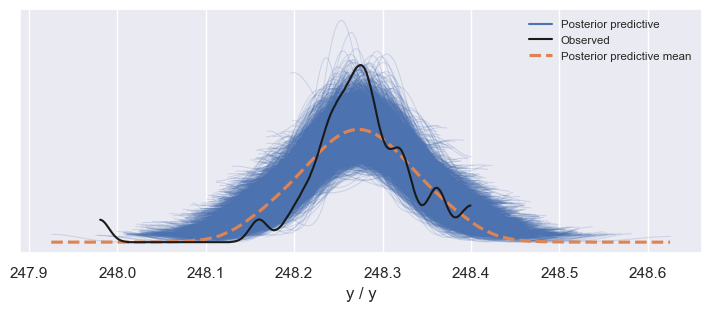

In [24]:

#the posterior predictive is improved compared to the Gaussian model fitted on the original data.
# Anyway, this requires the heuristic work of deciding which observation is an outlier.
# Moreover, this shows how sensitive can be the estimation of the normal model to outliers (we only removed one datum out of 66)
with model_newcomb_no_outliers:
    ppc_t = pm.sample_posterior_predictive(trace_newcomb_no_outliers)
    
az.plot_ppc(ppc_t);